In [1]:
!pip install -U quandl numpy pandas requests pandas-datareader DateTime yahoo_fin seaborn scipy numpy-financial

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import json
import requests
from yahoo_fin import stock_info as si
from datetime import datetime, timedelta

# Utils

In [3]:
def get_us_treasuries_yield():
    url = "https://quote.cnbc.com/quote-html-webservice/quote.htm"
    params = {
        "noform": "1",
        "partnerId": "2",
        "fund": "1",
        "exthrs": "0",
        "output": "json",
        "symbolType": "issue",
        "symbols": "5093148|5093149|5093150|15183113|5093151|5093158|5093159|19892965|5093160|135058359|5093168",
        "requestMethod": "extended",
    }
    data = requests.get(url, params=params).json()
    result = {
        "symbol": [],
        "last": [],
    }
    for q in data["ExtendedQuoteResult"]["ExtendedQuote"]:
        result["symbol"].append(q["QuickQuote"]["symbol"])
        result["last"].append(q["QuickQuote"]["last"])
    return pd.DataFrame.from_dict(result)


def weights_sampler(samples, sum_to, range_list):
    assert range_list[0] < range_list[1], "Range should be a list, the first element of which is smaller than the second"
    arr = np.random.uniform(low=range_list[0], high=range_list[1], size=samples)
    sum_arr = sum(arr)

    difference = sum(arr) - sum_to
    
    while abs(difference) > 1e-5:
        if difference < 0:
                for idx in np.random.choice(len(arr), int(abs(difference*1e5))):
                    if arr[idx] < range_list[1]:
                        arr[idx] += 1e-5

        if difference > 0:
                for idx in np.random.choice(len(arr), int(difference*1e5)):
                    if arr[idx] > range_list[0]:
                        arr[idx] -= 1e-5
        difference = sum(arr) - sum_to
    return arr

# Inputs

**tickers** - list of tickers in your portfolio

**historical_data_years** - number of years to fetch the historical data for


In [23]:
# Portfolio inputs:
tickers = ['SPY', 'QQQ', 'GLD', 'WMT', 'BA', 'JPM', 'DIS']
historical_data_years = 10

np.random.seed(123)

# Some dynamic input
treasury_bills_yield = get_us_treasuries_yield()
risk_free_rate = float(treasury_bills_yield.iloc[-1]["last"]) / 100
live_prices = [si.get_live_price(ticker) for ticker in tickers]

print("US Treasuries Yield:\n")
print(treasury_bills_yield)
print("\n30 years US treasuries yield used as risk free rate: ", risk_free_rate)
print("\nLive prices for your tickers:\n", "\n".join(t+" "+str(round(lp,2)) for t,lp in zip(tickers, live_prices)))

US Treasuries Yield:

   symbol   last
0    US1M  0.056
1    US3M  0.051
2    US6M  0.061
3    US1Y  0.157
4    US2Y  0.494
5    US3Y  0.843
6    US5Y  1.231
7    US7Y  1.477
8   US10Y  1.591
9   US20Y  2.018
10  US30Y  1.983

30 years US treasuries yield used as risk free rate:  0.01983

Live prices for your tickers:
 SPY 468.14
QQQ 397.63
GLD 174.5
WMT 141.94
BA 226.62
JPM 164.47
DIS 157.33


# Historical data

In this section we retrieve historical data for each asset for the period of **historical_data_years** and calculate basic statistics.

In [6]:
start = datetime.now() - timedelta(days = 365 * historical_data_years)
end = datetime.now()
print('Start date:', start.strftime("%d/%m/%Y"), 'End date:', end.strftime("%d/%m/%Y"))

Start date: 21/11/2011 End date: 18/11/2021


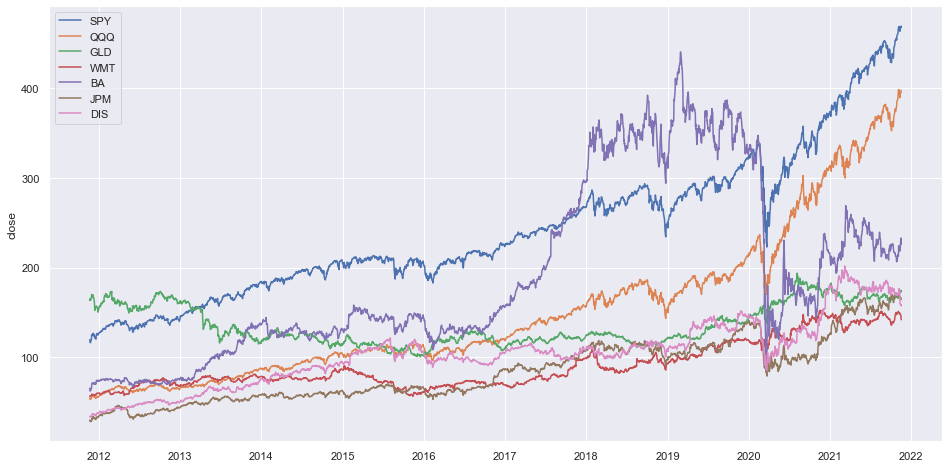

In [7]:
portfolio = {}

sns.set(rc = {'figure.figsize': (16,8)})

for ticker in tickers:
    tmp = si.get_data(ticker, start_date=start.strftime("%d/%m/%Y"), end_date=end.strftime("%d/%m/%Y"))
    tmp['daily_change'] = tmp['close'].pct_change()
    portfolio[ticker] = tmp['close']
    sns.lineplot(x=tmp.index, y='close', data=tmp, markers=True, label=ticker)

In [8]:
portfolio = pd.DataFrame.from_dict(portfolio)
portfolio.head()

,SPY,QQQ,GLD,WMT,BA,JPM,DIS
2011-11-21,119.660004,54.340000,163.500000,56.660000,65.559998,29.910000,34.330002
2011-11-22,119.190002,54.520000,165.309998,56.849998,64.349998,29.410000,34.020000
2011-11-23,116.559998,53.290001,164.830002,56.639999,62.360001,28.379999,33.400002
2011-11-25,116.339996,52.880001,163.399994,56.889999,62.779999,28.480000,33.509998
2011-11-28,119.709999,54.720001,166.630005,57.250000,64.989998,29.160000,34.070000


In [9]:
returns_portfolio = portfolio.pct_change()
returns_portfolio.head()

,SPY,QQQ,GLD,WMT,BA,JPM,DIS
2011-11-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-11-22,-0.003928,0.003312,0.011070,0.003353,-0.018456,-0.016717,-0.009030
2011-11-23,-0.022066,-0.022561,-0.002904,-0.003694,-0.030925,-0.035022,-0.018225
2011-11-25,-0.001887,-0.007694,-0.008676,0.004414,0.006735,0.003524,0.003293
2011-11-28,0.028967,0.034796,0.019768,0.006328,0.035202,0.023876,0.016711


# Covariance matrix

In [10]:
covariance_matrix = returns_portfolio.cov()
covariance_matrix

,SPY,QQQ,GLD,WMT,BA,JPM,DIS
SPY,0.000105,0.000114,0.000003,0.000057,0.000147,0.000131,0.000104
QQQ,0.000114,0.000145,0.000005,0.000062,0.000138,0.000118,0.000103
GLD,0.000003,0.000005,0.000092,0.000004,0.000003,-0.000016,-0.000004
WMT,0.000057,0.000062,0.000004,0.000149,0.000056,0.000056,0.000052
BA,0.000147,0.000138,0.000003,0.000056,0.000524,0.000220,0.000175
JPM,0.000131,0.000118,-0.000016,0.000056,0.000220,0.000292,0.000150
DIS,0.000104,0.000103,-0.000004,0.000052,0.000175,0.000150,0.000238


Text(0.5, 1.0, 'Portfolio Pearson correlation')

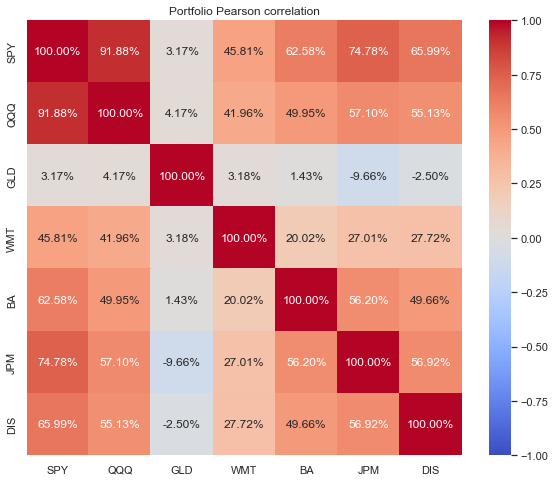

In [11]:
sns.set(rc = {'figure.figsize': (10, 8)})
sns.heatmap(
    returns_portfolio.corr(method='pearson'), 
    annot=True, 
    square=True, 
    fmt=".2%", 
    cmap=sns.color_palette("coolwarm", as_cmap=True),
    vmin=-1, vmax=1
).set_title('Portfolio Pearson correlation')

# Portfolio return and volatility

In [12]:
weight_portfolio = [0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]
portfolio_return = (returns_portfolio.mean()*252).dot(weight_portfolio)
portfolio_variance = np.transpose(weight_portfolio)@covariance_matrix@weight_portfolio*252
portfolio_volatility = np.sqrt(portfolio_variance)

print("Portfolio return is:", round(portfolio_return, 5))
print("Portfolio variance is:", round(portfolio_variance, 5))
print("Portfolio volatility is:", round(portfolio_volatility, 5))

Portfolio return is: 0.05387
Portfolio variance is: 0.00309
Portfolio volatility is: 0.05557


# Optimizing portfolio

In [13]:
pt_returns = []
pt_volatility = []
pt_weights = []

In [14]:
num_assets = len(portfolio.columns)
indivual_rets = returns_portfolio.mean()*252

#number of simulations
num_portfolios = 2000 #1000

#min and max weight of any stock in our portfolio
weights_range = [0.05, 0.2]

In [15]:
for port in range(num_portfolios):
    #Random generation of weights
    weights = weights_sampler(num_assets, 1, weights_range)
    pt_weights.append(weights)
    
    #Returns with these new weights
    returns = np.dot(weights, indivual_rets)
    pt_returns.append(returns)
    
    #portfolio variance
    variance = np.transpose(weights)@covariance_matrix@weights*252
    volatility = np.sqrt(variance)
    pt_volatility.append(volatility)

In [24]:
data = {'returns':pt_returns, 'volatility':pt_volatility}

for counter,symbol in enumerate(portfolio.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in pt_weights]
    
portfolios_V1 = pd.DataFrame(data)
portfolios_V1.head()

,returns,volatility,SPY weight,QQQ weight,GLD weight,WMT weight,BA weight,JPM weight,DIS weight
0,0.159329,0.169635,0.165370,0.103691,0.094998,0.143787,0.168240,0.123906,0.200005
1,0.161967,0.167979,0.096424,0.191749,0.104536,0.148209,0.182989,0.085987,0.190104
2,0.149875,0.160484,0.163738,0.102861,0.163431,0.115679,0.169606,0.113643,0.171038
3,0.154938,0.167181,0.108964,0.140029,0.177791,0.088000,0.192257,0.200006,0.092949
4,0.162111,0.170324,0.129092,0.154980,0.100934,0.136273,0.181544,0.128706,0.168460


Text(0, 0.5, 'Expected Returns')

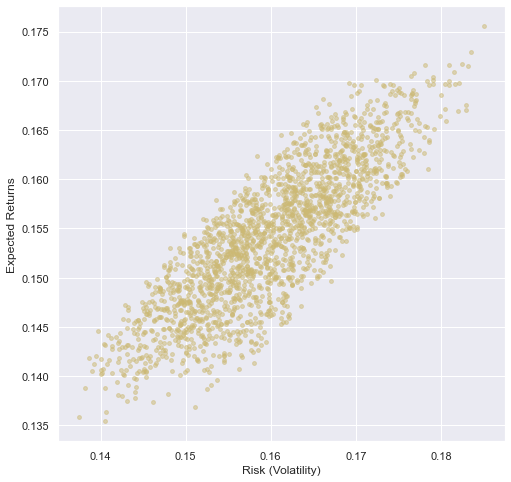

In [25]:
portfolios_V1.plot.scatter(x='volatility', y='returns', marker='o',color='y',
                           s=15, alpha=0.5,grid=True,figsize=[8,8])
plt.xlabel('Risk (Volatility)')
plt.ylabel('Expected Returns')

# Highest sharpe ratio

In [26]:
optimal_risky_pt = portfolios_V1.iloc[((portfolios_V1['returns'])/
                                       portfolios_V1['volatility']).idxmax()]
optimal_risky_pt

returns       0.144558
volatility    0.139748
SPY weight    0.119232
QQQ weight    0.196014
GLD weight    0.200004
WMT weight    0.169487
BA weight     0.054362
JPM weight    0.142145
DIS weight    0.118749
Name: 98, dtype: float64

Text(0, 0.5, 'Expected Returns')

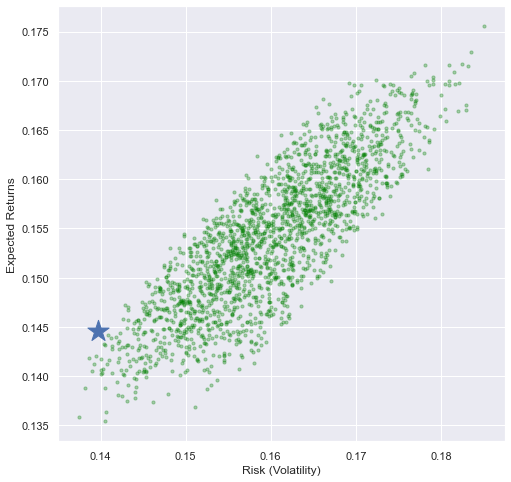

In [27]:
plt.subplots(figsize=(8,8))
plt.scatter(portfolios_V1['volatility'], portfolios_V1['returns'], marker='o',
            s=10, alpha=0.3,color='green')
plt.scatter(optimal_risky_pt[1], optimal_risky_pt[0], marker='*',
            s=500, color='b')
plt.xlabel('Risk (Volatility)')
plt.ylabel('Expected Returns')

In [28]:
opt_sharpe_ratio_rf = (optimal_risky_pt['returns']-risk_free_rate)/optimal_risky_pt['volatility']
print('Sharpe ratio in the optimized portfolio considering risk-free ratio:', round(opt_sharpe_ratio_rf, 5))
opt_sharpe_ratio_wrf = optimal_risky_pt['returns']/optimal_risky_pt['volatility']
print('Sharpe ratio in the optimized portfolio considering risk-free ratio:', round(opt_sharpe_ratio_wrf, 5))

Sharpe ratio in the optimized portfolio considering risk-free ratio: 0.89252
Sharpe ratio in the optimized portfolio considering risk-free ratio: 1.03441


## References:

- [Ivan Prodaiko's portfolio two stocks portfolio optimization](https://github.com/IvanProdaiko94/portfolio_analytics)

- [Multiple stock portfolio optimization](https://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/)

- [Weights generation logic](https://softwareengineering.stackexchange.com/questions/254301/algorithm-to-generate-n-random-numbers-between-a-and-b-which-sum-up-to-x)
